In [1]:
'''
Date: 28/Jan/2022
Auther: Yike Xie

Content: Figure 3 SVM
'''

'\nDate: 20/Jan/2022\nAuther: Yike Xie\nContent: Figure 3 in dengue paper\n'

In [117]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
#from numpy import *
from sklearn import svm

In [1]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [2]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [3]:
#rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_celltype(adata_kid) # 'cell_type_new', 'cell_subtype_new'

In [4]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_3/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

In [55]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].cat.categories.tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].cat.categories.tolist()

In [6]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [7]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells', 'signaling NK cells', 'cytotoxic NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.0, 0.5019607843137255),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [80]:
def frac_df(adata):     
    temp = adata[(adata.obs['cell_subtype_new'] != 'unknown') & (adata.obs['cell_subtype_new'] != 'doublets')].copy()
    temp = temp[(temp.obs['ID'] != '1_075_01') & (temp.obs['ID'] != '6_029_01')]
    cell_subtypes = temp.obs['cell_subtype_new'].unique().tolist()
    IDs = {cst: list(temp[temp.obs['cell_subtype_new'] == cst].obs['ID'].unique()) for cst in cell_subtypes}
    cds = ['Healthy', 'dengue', 'DWS', 'S_dengue']

    df = pd.DataFrame()
    fra_ct, cd, cst, patient = [], [], [], []

    for csti, ID in IDs.items():
        temp_cst = temp[temp.obs['cell_subtype_new'] == csti]
        ct = temp_cst.obs['cell_type_new'].unique()[0]
        for IDi in ID:
            cdi = temp_cst[temp_cst.obs['ID'] == IDi].obs['Condition'].unique()[0]
            cell_cst = temp_cst[temp_cst.obs['ID'] == IDi].obs.shape[0]
            total_ct = temp[(temp.obs['ID'] == IDi) & (temp.obs['cell_type_new'] == ct)].obs.shape[0]
           
            if total_ct == 0:
                continue
            cd.append(cdi)
            cst.append(csti)
            patient.append(IDi)
            fra_ct.append(cell_cst / total_ct)
            
    df['cst'] = cst
    df['Condition'] = cd
    df['ID'] = patient
    df['fra_ct'] = fra_ct
    
    df.set_index('cst', inplace=True)
    
    return df

In [98]:
df_frac = frac_df(adata_kid)
df_frac.set_index([ 'ID', df_frac.index,], inplace=True)

csts = [
'naive B cells',
 'memory B cells',
 'activated B cells',
 'non-proliferating plasmablasts',
 'proliferating plasmablasts',
 'CD4+ T cells',
 'CD8+ naive/memory T cells',
 'CD8+ effector T cells',
 'cytotoxic NK cells',
 'signaling NK cells',
 'classical monocytes',
 'non-classical monocytes',
 'intermediate monocytes',
]

IDs = adata_kid.obs['ID'].unique().tolist()
IDs.remove('1_075_01')
IDs.remove('6_029_01')
df = pd.DataFrame(np.zeros((len(IDs), len(csts))), index=IDs, columns=csts)

cond2 = []
for ID in IDs:
    cond2.append(df_frac.loc[(ID)]['Condition'][0])    
    for cst in csts:
        if (ID, cst) in df_frac.index:
            df.at[(ID, cst)] = df_frac.loc[(ID, cst)]['fra_ct']
            
df['Condition_2'] = cond2
df['Condition'] = 'infect'
df.loc[df['Condition_2'] == 'Healthy', 'Condition'] = 'Healthy'

df.to_csv('/home/yike/phd/dengue/dengue_children/paper_figures/final/references/Zhiyuan_refs/' + 'cell_abundance.tsv',
         sep='\t')

<ipython-input-436-3658d3c2b3a6>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


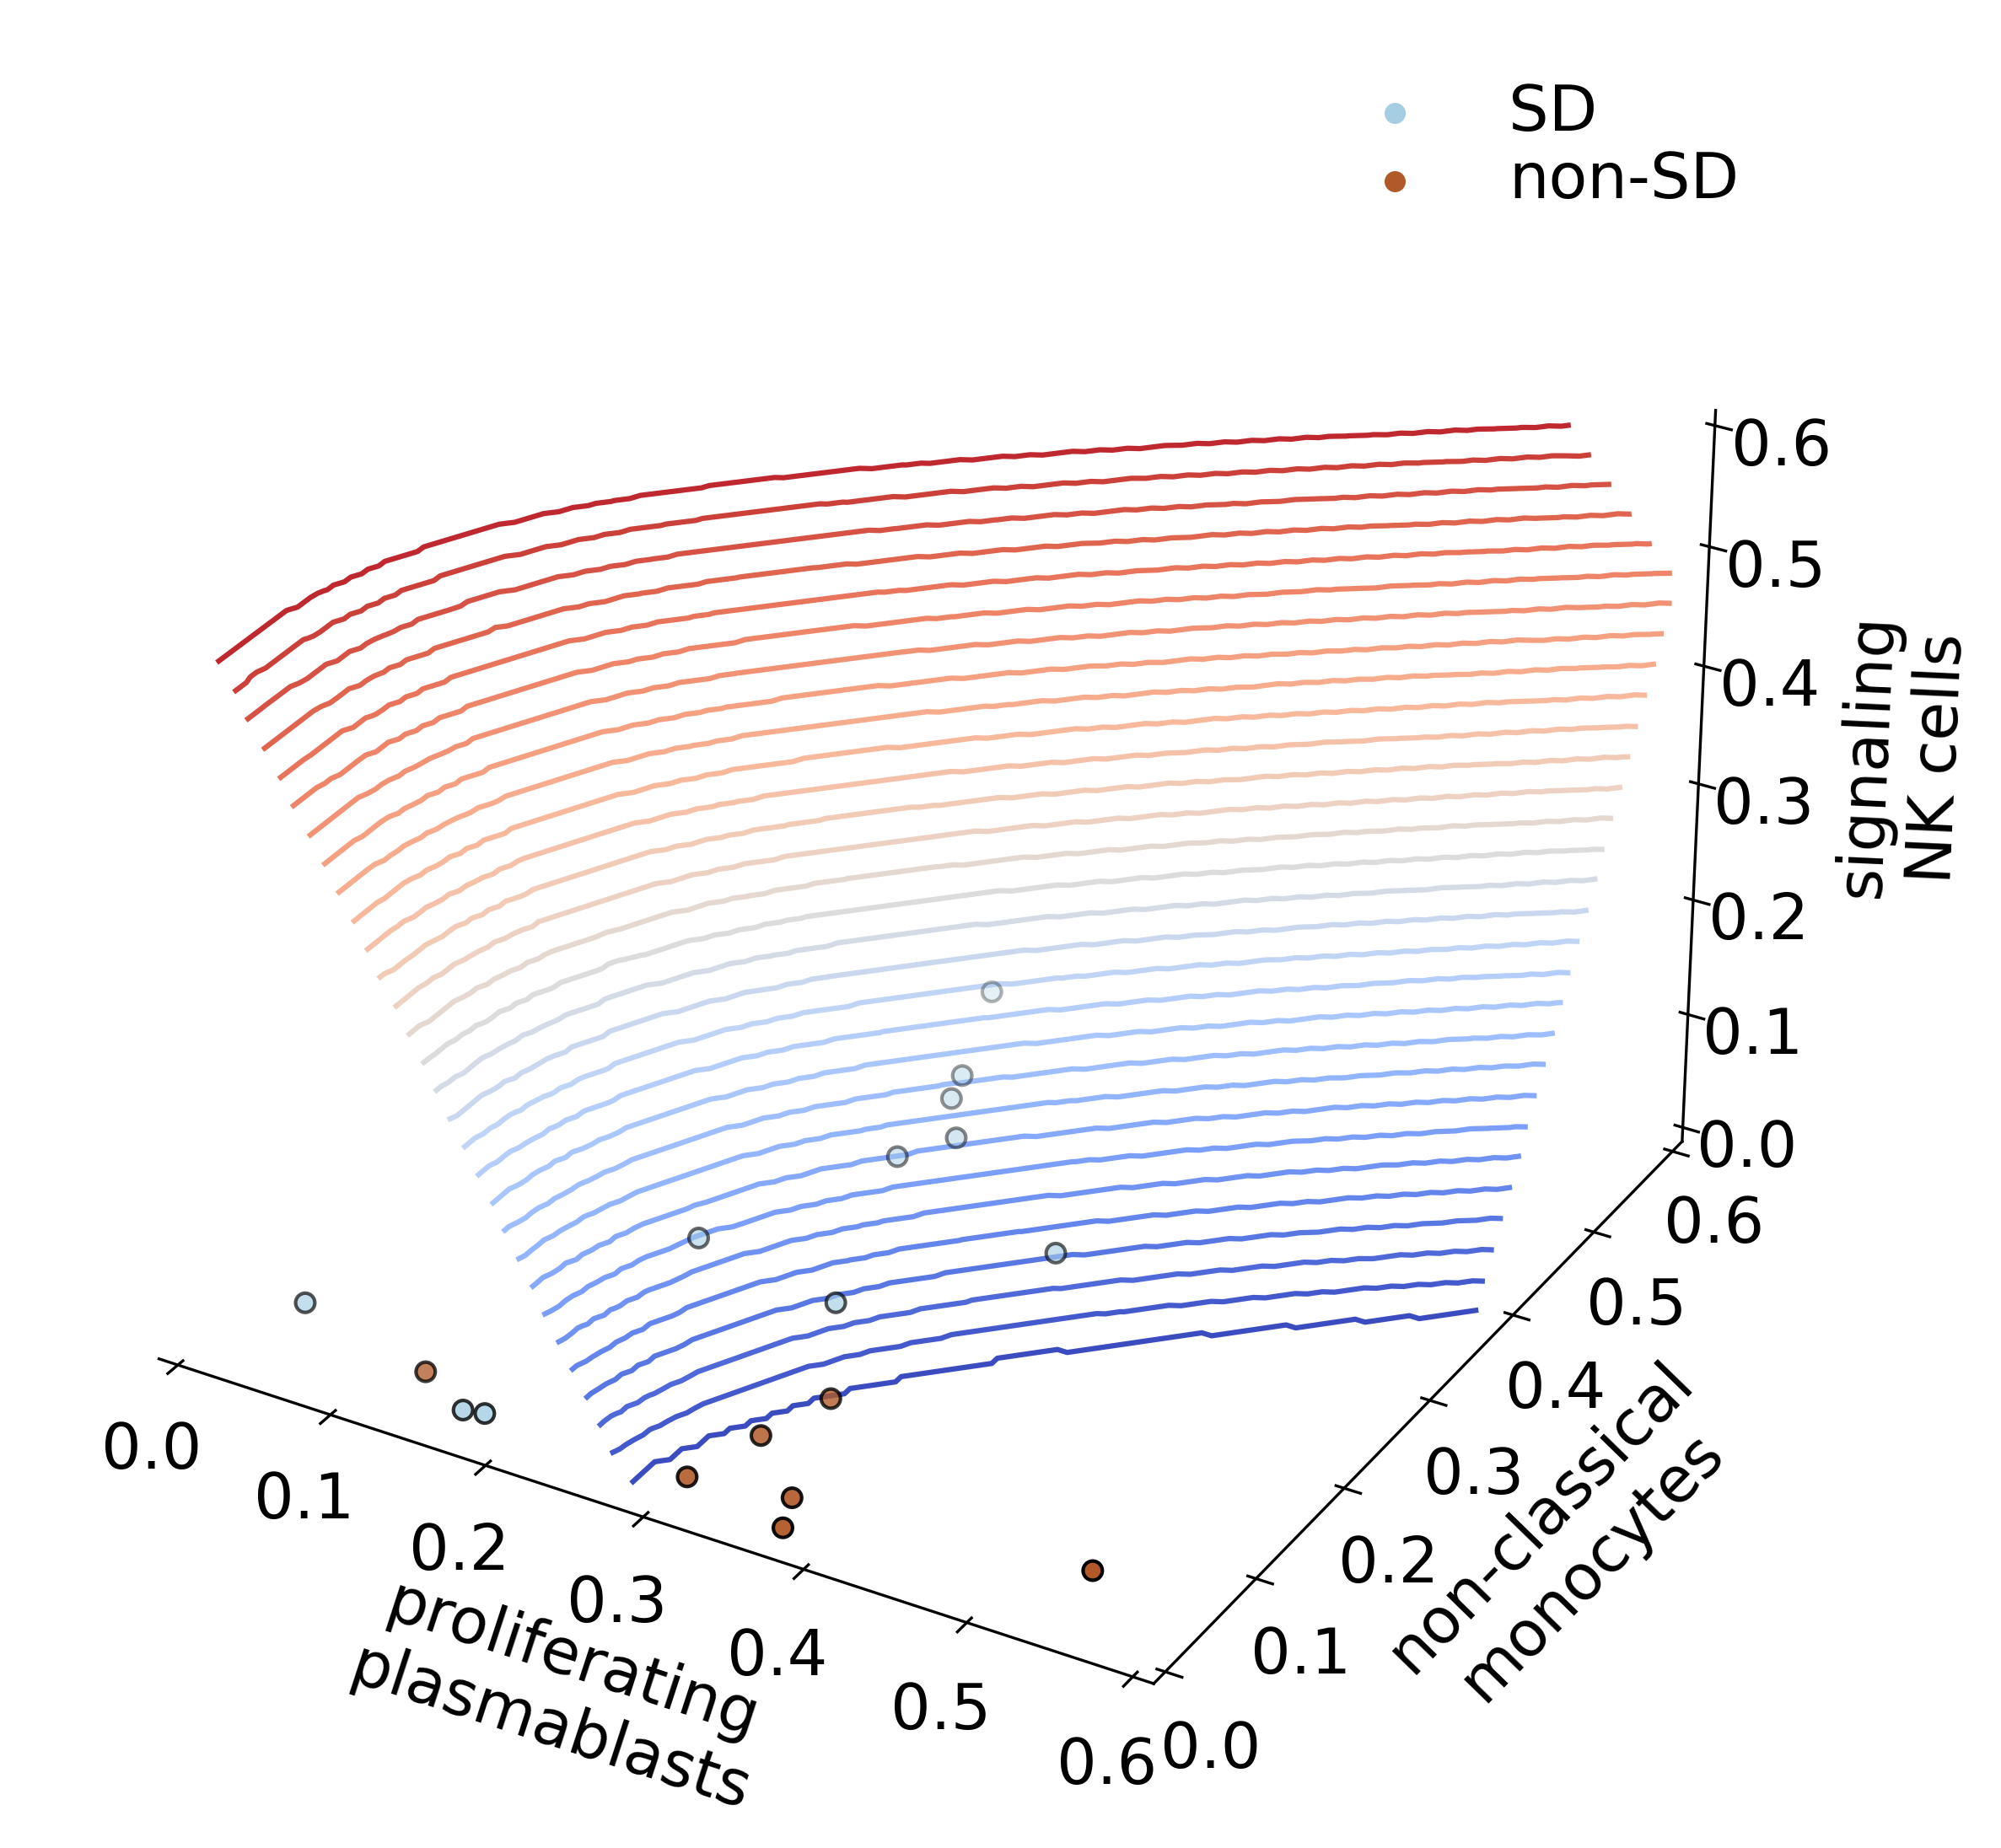

In [436]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm

df = pd.read_csv('/home/yike/phd/dengue/dengue_children/paper_figures/final/references/Zhiyuan_refs/' + 'cell_abundance.tsv',
         sep='\t', index_col=0)

#######################################
train_list = np.append(np.arange(1,16), 17)
vali_list = np.array([1])
celltype_list = ['proliferating plasmablasts', 'non-classical monocytes', 'signaling NK cells', 'Condition_2']

df_2 = df.loc[df.Condition_2 != 'Healthy', celltype_list]
df_2['Condition_3'] = False
df_2.loc[df_2.Condition_2 == 'S_dengue', 'Condition_3'] = True

#######################################
train_df = df_2.iloc[train_list]
train_m = train_df.iloc[:,0:3].values
train_label = train_df['Condition_3'].to_list()

vali_df = df_2.iloc[vali_list]
vali_m = vali_df.iloc[:,0:3].values
vali_label = vali_df['Condition_3'].to_list()

X = train_m
Y = train_label

clf = svm.NuSVC(kernel='poly', degree = 3, gamma='scale')
clf.fit(X, Y)

##############################################
xx, yy = np.meshgrid(np.linspace(0, 0.6, 100),
                         np.linspace(0, 0.6, 100),)

zz = []
for x, y in zip(xx.ravel(), yy.ravel()):
    z_list = np.linspace(0, 0.6, 100)
    for i, z in enumerate(z_list[:-1]):
        a = np.asarray([[x, y, z]])
#         b = np.asarray([[x, y, z_list[i+1]]])
#         if (clf.predict(a) < 0) & (clf.predict(b) > 0):
#             zz.append([z, z_list[i+1]].mean())

        if clf.predict(a) > 0:
            zz.append(z)
            break
    else:
        zz.append(0.6)
        
zz = np.asarray(zz).reshape(xx.shape) 

#############################################
from matplotlib import rcParams
rcParams['font.size']=18
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
# Bonus: To get rid of the grid as well:
ax.grid(False)

ax.scatter(df_2.iloc[:,0:3].values[:,0], df_2.iloc[:,0:3].values[:,1], df_2.iloc[:,0:3].values[:,2], s=30, 
           c=df_2.Condition_3, cmap=plt.cm.Paired, edgecolors='k')

ax.plot_surface(xx, yy , zz, cmap='gray', alpha=0.2)    
#ax.contour3D(xx, yy , zz, 30, cmap='coolwarm_r')

ax.set_xlim(0, 0.6)
ax.set_xticks([0, 0.2, 0.4, 0.6])
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_zlim(0, 0.6)
ax.set_zticks([0, 0.2, 0.4, 0.6])

ax.set_xlabel('proliferating\nplasmablasts', labelpad=15)
ax.set_ylabel('non-classical\nmonocytes', labelpad=15)
ax.set_zlabel('signaling NK cells', labelpad=15)

handles = []
labels = []
for ct, color in zip(['SD', 'non-SD'], plt.cm.Paired((11, 0))):
    h = ax.scatter([], [], [], marker='.', s=100, color=color,)
    handles.append(h)
    labels.append(ct)
ax.legend(handles, labels, frameon=False, labelspacing=0.1, loc='best')
plt.tight_layout()

In [464]:
idx = [[True, False][z in [0.6, 0]] for z in zz.ravel()]
idx = np.asarray(idx).reshape(xx.shape)

In [488]:
zz2 = zz * idx
#zz2 = np.where(zz2, 0, np.nan)

xx2 = xx * idx
#xx2 = np.where(xx2, 0, np.nan)

yy2 = yy * idx
#yy2 = np.where(yy2, 0, np.nan)